In [1]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
import math
from tqdm import tqdm 
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
path = '.'
train = path + '/yamaha_v0/train/'
test = path + '/yamaha_v0/valid/'

In [3]:
def get_folder_names(directory_path):
    folder_names = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]
    prefix = directory_path

    images = [prefix + element + '/rgb.jpg' for element in folder_names]
    labels = [prefix + element + '/labels.png' for element in folder_names]

    return np.array(images), np.array(labels)


In [4]:
train_images, train_labels = get_folder_names(train)
test_images, test_labels = get_folder_names(test)
train_images_folders, train_labels_folders = np.sort(train_images), np.sort(train_labels)
test_images_folders, test_labels_folders = np.sort(test_images), np.sort(test_labels)



In [5]:
def load_images(filename_list):
    images = []
    c = 0
    for filename in filename_list:
        img = cv.imread(filename)
        # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        if img is not None:
            img= cv.resize(img, (300, 300))

            images.append(img)



    return np.array(images)

In [6]:
train_images = load_images(train_images_folders)
train_labels = load_images(train_labels_folders)


test_images = load_images(test_images_folders)
test_labels = load_images(test_labels_folders)

In [7]:
# img = cv.cvtColor(train_labels[354], cv.COLOR_BGR2RGB)
# plt.imshow(img), plt.show()

IndexError: index 354 is out of bounds for axis 0 with size 11

In [8]:
classes = {0: [74, 144, 226],
           1: [139, 87, 42],
           2: [155, 155, 155],
           3: [59, 93, 4],
           4: [209, 225, 158],
           5: [184, 20, 124]}


In [9]:
def recreateImage(class_indices):
    image = np.zeros((class_indices.shape[0], class_indices.shape[1], 3))

    for CLASS, RGB in classes.items():
        # print(CLASS, RGB)
        rows, columns = np.where(class_indices == CLASS)
        image[rows, columns, :] = RGB


    return image.astype(int)

In [10]:
old_labels = train_labels
train_labels_indexed = np.zeros((old_labels.shape[0], old_labels.shape[1], old_labels.shape[2]))

print(old_labels.shape[0])

for index in tqdm(range(old_labels.shape[0]), desc="Processing", unit="iteration"):

    # print(index)

    label = old_labels[index]

    img_hsv = cv.cvtColor(label, cv.COLOR_BGR2HSV)

    mask_1 = cv.inRange(img_hsv,(85, 100, 20), (130, 255, 255)) # SKY
    mask_2 = cv.inRange(img_hsv,(0, 50, 20),(30, 255, 255)) # ROUGH TRAIL
    mask_3 = cv.inRange(img_hsv,(0, 10, 0),(60, 100, 255)) # SMOOTH TRAIL
    mask_4 = cv.inRange(img_hsv,(45, 100, 20),(80, 255, 150)) # HIGH VEGETATION
    mask_5 = cv.inRange(img_hsv,(40, 100, 150),(80, 255, 255)) # LOW VEGETATION
    mask_6 = cv.inRange(img_hsv,(130, 50, 150),(180, 255, 255)) # OBSTACLE


    labeledimg = np.dstack((mask_1, mask_2, mask_3, mask_4, mask_5, mask_6))
    # print(labeledimg[9, 6, :])
    # print(labeledimg[0, 0, :])
    # print(labeledimg[26, 57, :])
    # print(labeledimg[7, 0, :])
    # print(labeledimg[299, 299, :])
    # print(labeledimg[64, 62, :])
    # print(labeledimg[47, 8, :])
    # print(labeledimg[0, 78, :])

    labelindices = np.argmax(labeledimg, axis = 2)
    train_labels_indexed[index] = labelindices

    # plt.figure(figsize=(24, 8))




    # plt.subplot(191), plt.imshow(cv.cvtColor(label, cv.COLOR_BGR2RGB), cmap='gray'), plt.title('Original Image')
    # plt.subplot(192), plt.imshow(img_hsv, cmap='gray'), plt.title('HSV Image')
    # plt.subplot(193), plt.imshow(mask_1, cmap='gray'), plt.title('Sky')
    # plt.subplot(194), plt.imshow(mask_2, cmap='gray'), plt.title('Rough Trail')
    # plt.subplot(195), plt.imshow(mask_3, cmap='gray'), plt.title('Smooth Trail')
    # plt.subplot(196), plt.imshow(mask_4, cmap='gray'), plt.title('High Vegetation')
    # plt.subplot(197), plt.imshow(mask_5, cmap='gray'), plt.title('Low Vegetation')
    # plt.subplot(198), plt.imshow(mask_6, cmap='gray'), plt.title('Obstacle')
    # plt.subplot(199), plt.imshow(recreateImage(labelindices), cmap='gray'), plt.title('Recontructed Image')




11


Processing: 100%|██████████| 11/11 [00:00<00:00, 138.39iteration/s]


In [11]:
old_labels = test_labels
test_labels_indexed = np.zeros((old_labels.shape[0], old_labels.shape[1], old_labels.shape[2]))

print(old_labels.shape[0])

for index in tqdm(range(old_labels.shape[0]), desc="Processing", unit="iteration"):


    label = old_labels[index]

    img_hsv = cv.cvtColor(label, cv.COLOR_BGR2HSV)

    mask_1 = cv.inRange(img_hsv,(85, 100, 20), (130, 255, 255)) # SKY
    mask_2 = cv.inRange(img_hsv,(0, 50, 20),(30, 255, 255)) # ROUGH TRAIL 
    mask_3 = cv.inRange(img_hsv,(0, 10, 0),(60, 100, 255)) # SMOOTH TRAIL
    mask_4 = cv.inRange(img_hsv,(45, 100, 20),(80, 255, 255)) # HIGH VEGETATION
    mask_5 = cv.inRange(img_hsv,(40, 100, 150),(85, 255, 255)) # LOW VEGETATION
    mask_6 = cv.inRange(img_hsv,(140, 100, 20),(180, 255, 255)) # OBSTACLE

    labeledimg = np.dstack((mask_1, mask_2, mask_3, mask_4, mask_5, mask_6))
    labelindices = np.argmax(labeledimg, axis = 2)
    test_labels_indexed[index] = labelindices


    # plt.figure(figsize=(24, 8))




    # plt.subplot(191), plt.imshow(cv.cvtColor(label, cv.COLOR_BGR2RGB), cmap='gray'), plt.title('Original Image')
    # plt.subplot(192), plt.imshow(img_hsv, cmap='gray'), plt.title('HSV Image')
    # plt.subplot(193), plt.imshow(mask_1, cmap='gray'), plt.title('Sky')
    # plt.subplot(194), plt.imshow(mask_2, cmap='gray'), plt.title('Rough Trail')
    # plt.subplot(195), plt.imshow(mask_3, cmap='gray'), plt.title('Smooth Trail')
    # plt.subplot(196), plt.imshow(mask_4, cmap='gray'), plt.title('High Vegetation')
    # plt.subplot(197), plt.imshow(mask_5, cmap='gray'), plt.title('Low Vegetation')
    # plt.subplot(198), plt.imshow(mask_6, cmap='gray'), plt.title('Obstacle')
    # plt.subplot(199), plt.imshow(recreateImage(labelindices), cmap='gray'), plt.title('Recontructed Image')


145


Processing: 100%|██████████| 145/145 [00:01<00:00, 136.44iteration/s]


In [13]:
xTrain = torch.from_numpy(train_images).type(torch.float32)
yTrain = torch.from_numpy(train_labels_indexed).type(torch.LongTensor)
xTest = torch.from_numpy(test_images).type(torch.float32)
yTest = torch.from_numpy(test_labels_indexed).type(torch.LongTensor)

print(xTrain.size(), xTest.size())
print(yTrain.size(), yTest.size())

train = TensorDataset(xTrain, yTrain)
test = TensorDataset(xTest, yTest)

train_loader = DataLoader(train, shuffle = True, batch_size = 4)
test_loader = DataLoader(test, shuffle = True, batch_size = 1)

torch.Size([11, 300, 300, 3]) torch.Size([145, 300, 300, 3])
torch.Size([11, 300, 300]) torch.Size([145, 300, 300])


In [14]:
torch.save(train_loader, 'train_loader_CMUYamaha.pth')
torch.save(test_loader, 'test_loader_CMUYamaha.pth')

In [15]:
train_loader = torch.load('./train_loader_CMUYamaha.pth')
test_loader = torch.load('./test_loader_CMUYamaha.pth')

In [16]:
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes):
        super(PyramidPoolingModule, self).__init__()

        self.pool_sizes = pool_sizes
        self.pool_layers = nn.ModuleList()

        for pool_size in self.pool_sizes:
            self.pool_layers.append(nn.AdaptiveAvgPool2d(output_size=pool_size))

    def forward(self, x):
        pool_outputs = [layer(x) for layer in self.pool_layers]
        pool_outputs = [nn.functional.interpolate(output, size=x.size()[2:], mode='bilinear', align_corners=False) for output in pool_outputs]
        pool_outputs.append(x)  # Include the original input
        return torch.cat(pool_outputs, dim=1)

In [17]:

class SegNet(nn.Module):
  def __init__(self):
    super(SegNet, self).__init__()
    # d=0.5
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 7, stride = 2, padding = 80, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu = nn.ReLU()
    self.norm1 = nn.LocalResponseNorm(size = 5, alpha=0.0001, beta=0.75, k=1.0)
    self.conv2 = nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 7, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.conv3 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 5, stride = 1, padding = 1, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.conv4 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 5, stride = 1, padding = 1, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.conv5 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.spp = PyramidPoolingModule(in_channels= 1024, pool_sizes = [1, 3, 5, 7])
    self.up1 = nn.ConvTranspose2d(in_channels=5120, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    # self.up2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.up3 = nn.ConvTranspose2d(in_channels=256, out_channels=96, kernel_size=5, stride=1, padding=1, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.up4 = nn.ConvTranspose2d(in_channels=96, out_channels=6, kernel_size=9, stride=1, padding=0, dilation=4, groups=1,  bias = True, padding_mode = 'zeros')
    self.up5 = nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=8, stride=1, padding=0, dilation=7, groups=1,  bias = True, padding_mode = 'zeros')


  def forward(self, x):
    "Conv 1"
    conv1 = self.conv1(x)
    relu1 = self.relu(conv1)
    norm1 = self.norm1(relu1)
    "Conv 2"
    conv2 = self.conv2(norm1)
    relu2 = self.relu(conv2)
    "Conv 3"
    conv3 = self.conv3(relu2)
    relu3 = self.relu(conv3)
    "Conv4"
    conv4 = self.conv4(relu3)
    relu4 = self.relu(conv4)
    conv5 = self.conv5(relu4)
    spp = self.spp(conv5)
    up1 = self.up1(spp)
    relu_up1 = self.relu(up1)
    # print(relu_up1.size())
    # up2 = self.up2(relu_up1)
    # relu_up2 = self.relu(up2)
    # print(relu_up2.size())
    up3 = self.up3(relu_up1)
    relu_up3 = self.relu(up3)
    # print(relu_up3.size())
    up4 = self.up4(relu_up3)
    relu_up4 = self.relu(up4)
    # print(relu_up4.size())
    up5 = self.up5(relu_up4)
    # print(up5.size())



    return up5




In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import seaborn as sn
import pandas as pd

def createConfusionMatrix(groundtruth, prediction):

    y_pred, y_true = [],  []

    y_pred.extend(prediction.view(-1).tolist())
    y_true.extend(groundtruth.view(-1).tolist())

    classes = ('Forest', 'Small vegetation', 'Obstacles', 'Smooth Trail', 'Rough Trail', 'Sky')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    # df_cm_all = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        # columns = [i for i in classes])
    return cf_matrix

In [21]:
# The training loop

def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    eps= 0.01
    iou= []
    for epoch in range(epochs):
        correct = 0
        total = 0
        running_loss = 0.0
        IoU= 0
        for i, (images, labels) in enumerate(tqdm(train_loader, desc="Processing", unit="item")):
            images = images.permute(0, 3, 1, 2)

            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            # print(labels.size(), outputs.size())
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            df_cm = createConfusionMatrix(labels, predicted)
            r, c = df_cm.shape

            df_cm_all = np.zeros((6, 6))
            df_cm_all[:r, :c] = df_cm
            intersection = np.diag(df_cm_all)
            ground_truth_set = df_cm_all.sum(axis=1)
            predicted_set = df_cm_all.sum(axis=0)
            union = ground_truth_set + predicted_set - intersection
            IoU = IoU + intersection / (union.astype(np.float32) + eps)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()

            if i == (len(train_loader) - 1):
                fig, axes = plt.subplots(1, 2, figsize=(18, 4))
                axes[0].imshow(predicted.cpu().numpy()[0])
                axes[1].imshow(labels.cpu().numpy()[0])
                plt.show()
                print('Loss: ', running_loss/len(train_loader))
                print('Mean IOU: ', np.mean(IoU)/len(train_loader))
            # print('Pixel Accuracy = {} %'.format(round(correct * 100/total, 2)))


            if plot:
              info = { ('loss_' + model_name): loss.item() }

        PATH = './pspnet_results.pt'
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'iou': np.mean(IoU)/len(train_loader),
            'loss': running_loss/len(train_loader),
            }, PATH)


        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, running_loss/len(train_loader)))
        print('Epoch [{}/{}], Mean IoU: {:.4f}'.format(epoch+1, epochs, np.mean(IoU)/len(train_loader)))
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)
        iou.append(np.mean(IoU)/len(train_loader))

    return val_error,val_loss_values,train_error,train_loss_values, iou


Processing:  67%|██████▋   | 2/3 [03:42<01:50, 110.90s/item]

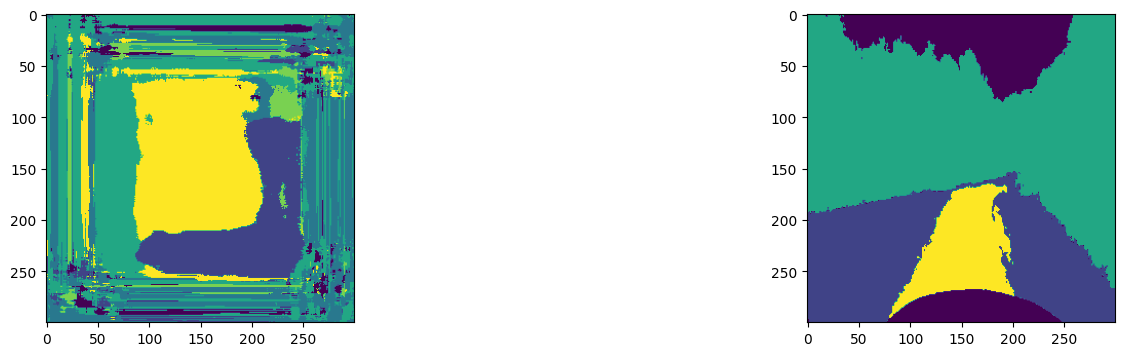

Processing: 100%|██████████| 3/3 [04:59<00:00, 99.84s/item] 


Loss:  2.0438382228215537
Mean IOU:  0.09449620177963947
Epoch [1/200], Loss: 2.0438
Epoch [1/200], Mean IoU: 0.0945


Processing:  67%|██████▋   | 2/3 [03:38<01:48, 108.67s/item]

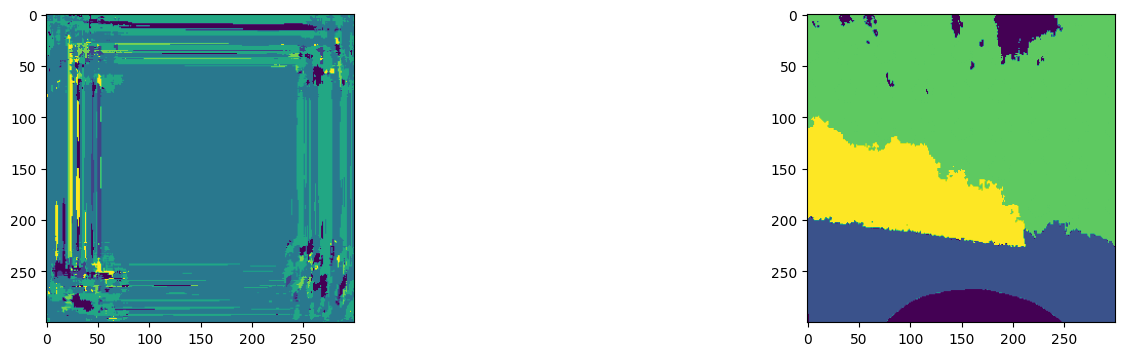

Processing: 100%|██████████| 3/3 [04:57<00:00, 99.13s/item] 


Loss:  1.7699577411015828
Mean IOU:  0.09417156974235696
Epoch [2/200], Loss: 1.7700
Epoch [2/200], Mean IoU: 0.0942


Processing:   0%|          | 0/3 [00:00<?, ?item/s]

In [22]:
model = SegNet().to(device)
epochs = 200
class_weights = torch.tensor([1.0, 3.0, 3.0, 1.0, 1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight= class_weights)

# lr=0.001, weight_decay=0.0001
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)
val_error,val_loss_values,train_error,train_loss_values, iou= train(model, optimizer, criterion, train_loader, test_loader, epochs, 'cnn_curve', True)